# Covertype

In [1]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from jax import config
config.update("jax_debug_nans", False)
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
import haiku as hk
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice

key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

from functools import partial
import kernels
import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import optax

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# # set up exporting
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# # save figures by using plt.savefig('title of figure')

In [3]:
%matplotlib inline

# Data

In [4]:
data = scipy.io.loadmat('/home/lauro/code/msc-thesis/wang_svgd/data/covertype.mat')
features = data['covtype'][:, 1:]
features = onp.hstack([features, onp.ones([features.shape[0], 1])]) # add intercept term

labels = data['covtype'][:, 0]
labels[labels == 2] = 0

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

num_features = features.shape[-1]

In [38]:
batch_size = 10**4
num_datapoints = len(x_train)
num_batches = num_datapoints // batch_size

def get_batches(x, y, n_steps=num_batches*2, batch_size=batch_size):
    """Split x and y into batches"""
    assert len(x) == len(y)
    n = len(x)
    idxs = onp.random.choice(n, size=(n_steps, batch_size))
    for idx in idxs:
        yield x[idx], y[idx]
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

# Model

In [39]:
a0, b0 = 1, 0.01 # hyper-parameters
# note that b0 is inverse scale, so this means alpha big, 1/alpha small! gaussian narrow! dunno why, check paper

# a0, b0 = 1, 10 # b approx equals variance

Root = tfd.JointDistributionCoroutine.Root

def get_model(features_batch):
    def model():
        """generator"""
        log_alpha = yield Root(tfd.ExpGamma(a0, b0, name="log_alpha"))                                      # scalar
        w = yield tfd.Sample(tfd.Normal(0., 1/np.exp(log_alpha/2)), sample_shape=(num_features,), name="w") # shape (num_features,)
        log_odds = jnp.dot(features_batch, w)                                                               # shape (len(features_batch),)
        _ = yield tfd.Independent(tfd.Bernoulli(logits=log_odds), name="labels")                            # shape (len(features_batch),) in {0, 1}
    return model


def get_logp(x_batch, y_batch):
    """Stochastic estimate of the log-density (up to additive constant)
    based on batch"""
    batchsize = len(x_batch)
    def logp(params):
        dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_batch), validate_args=True)
        return dist.log_prob(tuple(params) + (y_batch,)) * num_datapoints / batchsize # TODO change back????
    return logp

dist_first_batch = tfd.JointDistributionCoroutineAutoBatched(get_model(x_train[:batch_size*10]))
# key, subkey = random.split(key)
# dist.sample(seed=subkey)

# Run inference using minibatches

We can ravel (flatten) and unravel parameters like so:

In [40]:
params = dist_first_batch.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params
# [a == b for a, b in zip(unravel(params_flat), params)]

In [41]:
def get_flat_logp(x_batch, y_batch):
    logp = get_logp(x_batch, y_batch)
    def flat_logp(params_flat):
        return logp(unravel(params_flat))
    return flat_logp

@jit
def sum_logp(x_batch, y_batch, flat_particles):
    logp = get_flat_logp(x_batch, y_batch)
    return np.sum(vmap(logp)(flat_particles))

def ravel(params):
    flat, _ = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)


def get_probs(params):
    """
    Argument: sampled model parameters (single sample! need to vmap over sample batch)
    Returns logits shaped (n,)"""
    test_dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_test))
    dists, _ = test_dist.sample_distributions(seed=random.PRNGKey(0), value=params + (None,))
    probs = dists[-1].distribution.probs_parameter() # spits out probability of y=1
    return probs

def get_preds(params):
    """
    Argument: sampled model parameters (batch)
    Returns predictions on test set (ignoring NaNs)
    """
    probs = vmap(get_probs)(params) # shape (n_samples, n_data)
    return (np.nanmean(probs, axis=0) > 0.5).astype(np.int32) # IS THIS CORRECT??

@jit
def test_accuracy(params):
    """
    Argument: sampled model parameters (batch). Unflattened!!
    Returns accuracy on test set
    """
    return np.mean(get_preds(params) == y_test)


# test loglikelihood
test_batches = get_batches(x_test, y_test, batch_size=batch_size)
train_batches = get_batches(x_train, y_train, batch_size=batch_size)


def test_logp(flat_particles):
    xtest, ytest = next(test_batches)
    return sum_logp(xtest, ytest, flat_particles)


def train_logp(flat_particles):
    xtrain, ytrain = next(test_batches)
    return sum_logp(xtrain, ytrain, flat_particles)

def sample(key):
    return dist_first_batch.sample(100, seed=key)[:-1]

def sample_flat(key):
    return batch_ravel(sample(key))

### samples from prior

In [42]:
key, subkey = random.split(key)

In [43]:
samples = sample(key)

### run model

In [53]:
NUM_VALS = 30 # number of test accuracy evaluations per run
NUM_EPOCHS = 50
NUM_STEPS = num_batches*NUM_EPOCHS

In [70]:
# schedule = utils.polynomial_schedule
# schedule = optax.constant_schedule(1.)

def run_sgld(key, init_batch, lr):
    """init_batch is a batch of initial samples / particles."""
    key, subkey = random.split(key)
#     sgld_opt = utils.scaled_sgld(subkey, lr, schedule)
    sgld_opt = utils.sgld(lr, 0)
    init_batch_flat = batch_ravel(init_batch)

    def energy_gradient(params, particles, aux=True):
        """params = [batch_x, batch_y]"""
        logp = get_flat_logp(*params)
        log_probs, grads = vmap(value_and_grad(logp))(particles)
        if aux:
            return -grads, {"logp": np.sum(log_probs)}
        else:
            return -grads

    particles = models.Particles(key, energy_gradient, init_batch_flat, custom_optimizer=sgld_opt) # learning_rate=1e-2
    test_batches = get_batches(x_test, y_test)
    for i, batch_xy in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        particles.step(batch_xy)
        if i % (NUM_STEPS//NUM_VALS)==0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": sum_logp(*next(test_batches), particles.particles.training),
            }
            metrics.append_to_log(particles.rundata, stepdata)
    particles.done()
    return batch_unravel(particles.particles.training), particles

In [55]:
# TODO: check if I'm doing batching right
# cause it seems test accuracy and test likelihood don't track the 
# new batch likelihood, even tho those should be the same

In [56]:
# Run samplers
key, subkey = random.split(key)
init_batch = dist_first_batch.sample(100, seed=subkey)[:-1]
key, subkey = random.split(key)

sgld_samples, sgld_p = run_sgld(subkey, init_batch, 1e-5)
sgld_aux = sgld_p.rundata

2301it [01:19, 28.84it/s]                          


## Evaluate samples on test set

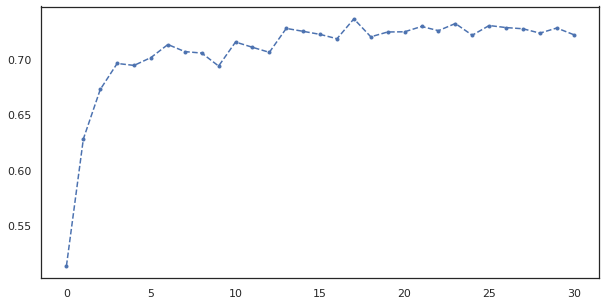

In [57]:
plt.subplots(figsize=[10, 5])
plt.plot(sgld_aux["accuracy"], "--.")

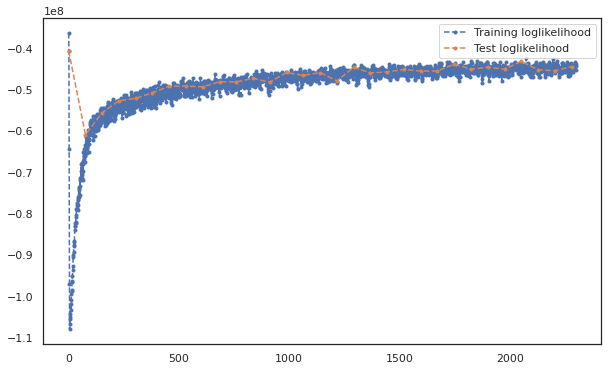

In [58]:
spaced_idx = np.arange(0, NUM_STEPS, NUM_STEPS // NUM_VALS)

# Test loglikelihood
plt.subplots(figsize=[10, 6])
plt.plot(sgld_aux["training_logp"], "--.", label="Training loglikelihood")
plt.plot(spaced_idx, sgld_aux["test_logp"], "--.", label="Test loglikelihood")
plt.legend()

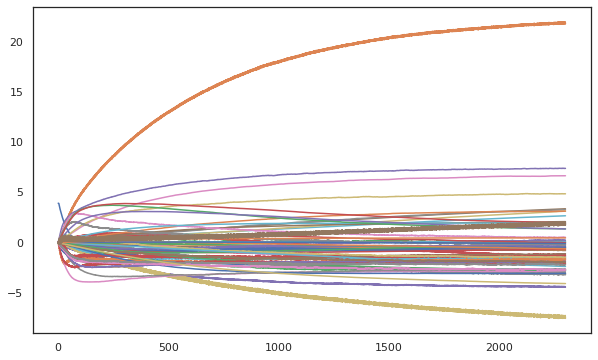

In [59]:
plt.subplots(figsize=[10, 6])
plt.plot(sgld_aux["training_mean"]);
l = plt.ylim()

In [60]:
# plt.subplots(figsize=[8, 6])
# plt.plot(batch_ravel(samples));
# plt.ylim(l)

In [61]:
# %matplotlib inline
# plt.subplots(figsize=[15, 8])
# plt.plot([base_lr*utils.polynomial_schedule(step) for step in range(NUM_STEPS)])
# plt.plot([np.sqrt(2*base_lr*utils.polynomial_schedule(step)) for step in range(NUM_STEPS)])
# plt.yscale("log")
# # plt.ylim(1e-2, 2e-1)

# SGLD Sweep

In [71]:
key, subkey = random.split(key)
init_batch = dist_first_batch.sample(100, seed=subkey)[:-1]

key, subkey = random.split(key)
def sgld_acc(lr):
    _, particles = run_sgld(subkey, init_batch, lr)
    acc = particles.rundata["accuracy"]
    return np.mean(np.array(acc[-10:]))

def print_accs(lrs, accs):
    accs = np.asarray(accs)
    plt.plot(lrs, accs, "--.")
    plt.xscale("log")

2301it [01:19, 29.11it/s]                          
2301it [01:15, 30.56it/s]                          
2301it [01:14, 30.84it/s]                          
2301it [01:16, 30.03it/s]                          
2301it [01:16, 30.13it/s]                          
2301it [01:16, 30.23it/s]                          
2301it [01:14, 30.81it/s]                          
2301it [01:14, 30.85it/s]                          
2301it [01:17, 29.58it/s]                          
2301it [01:14, 30.94it/s]                          
2301it [01:14, 30.89it/s]                          
2301it [01:14, 30.81it/s]                          
2301it [01:22, 27.91it/s]                          
2301it [01:21, 28.20it/s]                          
2301it [01:20, 28.49it/s]                          


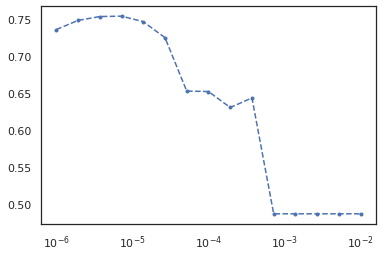

In [72]:
accs_sweep = []
lrs = np.logspace(-6, -2, 15)
for lr in lrs:
    accs_sweep.append(sgld_acc(lr))
print_accs(lrs, accs_sweep)

# calibration curve

In [73]:
@jit
def batch_probs(param_batch):
    """Returns test probabilities P(y=1) for
    all y in the test set"""
    return np.mean(vmap(get_probs)(param_batch), axis=0)

Text(0.5, 1.0, 'SGLD Calibration')

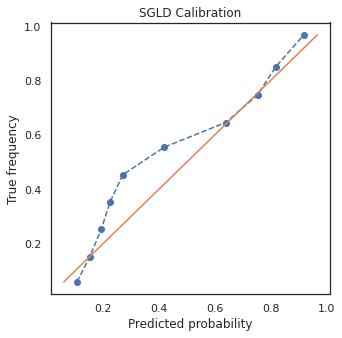

In [74]:
fig, ax = plt.subplots(figsize=[5, 5])

probs = batch_probs(sgld_samples)
true_freqs, bins = calibration_curve(y_test, probs, n_bins=10)
ax.plot(true_freqs, bins, "--o")
#     print(bins)
ax.plot(bins, bins)
ax.set_ylabel("True frequency")
ax.set_xlabel("Predicted probability")
ax.set_title("SGLD Calibration")

# Try with TFP

In [75]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [76]:
bs = 10**4
nb = num_datapoints // bs # num batches
batches = get_batches(x_train, y_train, n_steps=10, batch_size=bs)
nb

46

In [26]:
xx, yy = next(batches)
target_log_prob = get_flat_logp(xx, yy)

In [27]:
# kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob, step_size=1e-2)
# kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=2e-5)

@jit
def run_chain(key, state):
    return tfp.mcmc.sample_chain(nb*10,
      current_state=state,
      kernel=kernel,
      trace_fn = None,
      num_burnin_steps=0,
      seed=key)

In [28]:
m = 100
key, subkey = random.split(key)
init_batch = dist_first_batch.sample(m, seed=subkey)[:-1]
init_batch = batch_ravel(init_batch)

In [29]:
key, subkey = random.split(key)
vstates = vmap(run_chain)(random.split(subkey, m), init_batch)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


In [30]:
tfp_samples = vstates[-1]
print(np.mean(np.isnan(tfp_samples)))
test_accuracy(batch_unravel(tfp_samples))

0.0


DeviceArray(0.70798516, dtype=float32)

In [31]:
@jit
def tfp_accuracy(lr, key):
    kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob_fn=target_log_prob, step_size=lr)

    def run_chain(rngkey, state):
        return tfp.mcmc.sample_chain(nb*10,
          current_state=state,
          kernel=kernel,
          trace_fn = None,
          num_burnin_steps=0,
          seed=rngkey)

    key, subkey = random.split(key)
    m = 100
    key, subkey = random.split(key)
    init_batch = dist_first_batch.sample(m, seed=subkey)[:-1]
    init_batch = batch_ravel(init_batch)
    vstates = vmap(run_chain)(random.split(subkey, m), init_batch)
    return test_accuracy(batch_unravel(vstates[-1]))

In [32]:
tfp_accuracy(5e-7, subkey)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


DeviceArray(0.63109386, dtype=float32)

  0%|          | 0/15 [00:00<?, ?it/s]/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '
100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


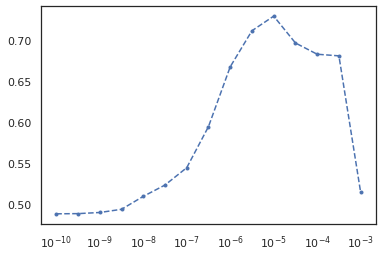

In [36]:
tfp_accs_sweep = []
lrs = np.logspace(-10, -3, 15)
for lr in tqdm(lrs):
    tfp_accs_sweep.append(tfp_accuracy(lr, subkey))
print_accs(lrs, tfp_accs_sweep)

In [37]:
lrs[np.array(tfp_accs_sweep).argmax()]

DeviceArray(1.e-05, dtype=float32)